# Model trained without outliers



In [1]:
from google.colab import drive
drive.mount('/gdrive')
current_dir = "/gdrive/My Drive/ANN-1stChallenge"

%cd $current_dir

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1SsYTSWVYK18RYEggHgY0ijnOvaI-DARa/ANN-1stChallenge


In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

# Set the used f1 type as macro, as using weighted benefits over-represented classes if they are very unbalanced
f1_average = 'macro'

PyTorch version: 2.8.0+cu126
Device: cuda


# Data loading

In [3]:
BASE_PATH = "datasets/"

# Load each csv
TRAIN_PATH = BASE_PATH + "pirate_pain_train.csv"
TRAIN_LABELS_PATH = BASE_PATH + "pirate_pain_train_labels.csv"
TEST_PATH = BASE_PATH + "pirate_pain_test.csv"
SUBMISSION_PATH = BASE_PATH + "sample_submission.csv"

X_train = pd.read_csv(TRAIN_PATH)
y_train = pd.read_csv(TRAIN_LABELS_PATH)

X_test = pd.read_csv(TEST_PATH)

In [4]:
label_encoder = LabelEncoder()

# Fit and transform the 'label' column in y_train
y_train['label_encoded'] = label_encoder.fit_transform(y_train['label'])

# Display the mapping of original labels to encoded numbers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

y_train = y_train.drop('label', axis=1)

Label Mapping:
{'high_pain': np.int64(0), 'low_pain': np.int64(1), 'no_pain': np.int64(2)}


In [5]:
# Categorical features which will be label-encoded
categorical_features = ['n_legs', 'n_hands', 'n_eyes']

encoders = {}

for col in categorical_features:
    encoders[col] = LabelEncoder() # Use same encoder for train and test

    X_train[col + '_encoded'] = encoders[col].fit_transform(X_train[col])
    X_test[col + '_encoded'] = encoders[col].transform(X_test[col])

    print(f"Label mapping for {col}: {dict(zip(encoders[col].classes_, encoders[col].transform(encoders[col].classes_)))}")

X_train = X_train.drop(categorical_features, axis=1)
X_test = X_test.drop(categorical_features, axis=1)

Label mapping for n_legs: {'one+peg_leg': np.int64(0), 'two': np.int64(1)}
Label mapping for n_hands: {'one+hook_hand': np.int64(0), 'two': np.int64(1)}
Label mapping for n_eyes: {'one+eye_patch': np.int64(0), 'two': np.int64(1)}


# Data preprocessing

In [6]:
# Merge X_train and y_train based on 'sample_index'
df = pd.merge(X_train, y_train, on='sample_index')

In [7]:
# Drop useless columns
columns_to_drop = [
    'time',
    'pain_survey_1',
    'pain_survey_2',
    'pain_survey_3',
    'pain_survey_4',
    'n_legs_encoded',
    'n_hands_encoded',
    'n_eyes_encoded',
    'joint_11',         # Highly correlated with joint_10
    'joint_30'          # Constant value
]

print(f"Columns to drop: {columns_to_drop}")
df = df.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

Columns to drop: ['time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs_encoded', 'n_hands_encoded', 'n_eyes_encoded', 'joint_11', 'joint_30']


In [8]:
def remove_outliers_iqr(df, column_name, QL_v, QH_v):
    """
    Removes outliers from a dataframe based on the IQR method for a specific column.
    This function identifies outlier samples and removes all rows associated with them.

    Args:
        df (pd.DataFrame): The input dataframe. Must contain 'sample_index'.
        column_name (str): The name of the column to check for outliers.
        QL_v (float): The lower quantile value for the IQR.
        QH_v (float): The upper quantile value for the IQR.

    Returns:
        pd.DataFrame: The dataframe with outlier samples removed.
        list: A list of the sample_index values that were identified as outliers.
    """
    # We only need to consider the unique max value for each sample
    unique_values = df[['sample_index', column_name]].drop_duplicates()

    QL = unique_values[column_name].quantile(QL_v)
    QH = unique_values[column_name].quantile(QH_v)
    IQR = QH - QL

    # Define the outlier boundaries
    lower_bound = QL - 1.5 * IQR
    upper_bound = QH + 1.5 * IQR

    print(f"Identifying outliers in '{column_name}'...")
    print(f"Q1: {QL:.4f}, Q3: {QH:.4f}, IQR: {IQR:.4f}")
    print(f"Outlier bounds: < {lower_bound:.4f} or > {upper_bound:.4f}")

    # Find the 'sample_index' of the outliers
    outlier_samples = unique_values[
        (unique_values[column_name] < lower_bound) | (unique_values[column_name] > upper_bound)
    ]
    outlier_indices = outlier_samples['sample_index'].tolist()

    if not outlier_indices:
        print("No outliers found.")
        return df, []

    print(f"Found {len(outlier_indices)} outlier samples: {outlier_indices}")

    # Filter the original dataframe to remove all rows belonging to these outlier samples
    df_cleaned = df[~df['sample_index'].isin(outlier_indices)].copy()

    print(f"Original shape: {df.shape}, Cleaned shape: {df_cleaned.shape}")

    return df_cleaned, outlier_indices

In [9]:
# @title Drop outliers on middle columns
Q3 = 0.9996
# Each middle column contains  outliers which make the model perform worse, so we find and drop them
for i in range(13, 26):
    df, _ = remove_outliers_iqr(df, f'joint_{i:02d}', 0, Q3)
print(f"final samples: {df['sample_index'].nunique()}")

Identifying outliers in 'joint_13'...
Q1: 0.0000, Q3: 0.0319, IQR: 0.0319
Outlier bounds: < -0.0479 or > 0.0798
No outliers found.
Identifying outliers in 'joint_14'...
Q1: 0.0000, Q3: 0.0196, IQR: 0.0196
Outlier bounds: < -0.0295 or > 0.0491
Found 9 outlier samples: [44, 92, 123, 123, 180, 280, 439, 465, 518]
Original shape: (105760, 31), Cleaned shape: (104480, 31)
Identifying outliers in 'joint_15'...
Q1: 0.0000, Q3: 0.0248, IQR: 0.0248
Outlier bounds: < -0.0372 or > 0.0620
Found 2 outlier samples: [526, 559]
Original shape: (104480, 31), Cleaned shape: (104160, 31)
Identifying outliers in 'joint_16'...
Q1: 0.0000, Q3: 0.0182, IQR: 0.0182
Outlier bounds: < -0.0273 or > 0.0455
Found 2 outlier samples: [252, 418]
Original shape: (104160, 31), Cleaned shape: (103840, 31)
Identifying outliers in 'joint_17'...
Q1: 0.0000, Q3: 0.0837, IQR: 0.0837
Outlier bounds: < -0.1256 or > 0.2093
Found 3 outlier samples: [381, 381, 381]
Original shape: (103840, 31), Cleaned shape: (103680, 31)
Identif

In [10]:
# @title Train/Validation split
n_series = len(y_train)

VAL_SPLIT = 0.2 # Split used for the validation set
val_size = int(VAL_SPLIT * n_series)
train_size = n_series - val_size

sample_ids = y_train['sample_index'].unique()
random.seed(SEED)
random.shuffle(sample_ids)

train_samples = sample_ids[:train_size] # Samples used for training
val_samples = sample_ids[train_size:] # Samples used for validation

print(f"Train samples: {len(train_samples)}, validation samples: {len(val_samples)}")

df_train = df[df['sample_index'].isin(train_samples)]
df_val = df[df['sample_index'].isin(val_samples)]

print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')

Train samples: 529, validation samples: 132
Training set shape: (78560, 31)
Validation set shape: (19040, 31)


In [11]:
# @title Scaling
# Scale only joints columns
scale_columns = [col for col in df_train.columns if col.startswith('joint')]

# Use minmax scaling, to keep the same shape
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

for c in scale_columns:
    # Scale columns, using only train data
    df_train[c] = (df_train[c] - mins[c]) / (maxs[c] - mins[c])
    df_val[c] = (df_val[c] - mins[c]) / (maxs[c] - mins[c])
    X_test[c] = (X_test[c] - mins[c]) / (maxs[c] - mins[c])

In [12]:
# Define a function to build sequences from the dataset
def build_sequences(df, features, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp = df[df['sample_index'] == id][features].values

        # Retrieve the activity label for the current ID
        # Assuming the label column exists in the dataframe passed to the function
        label = df[df['sample_index'] == id]['label_encoded'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        # The padding should have the same number of columns as the features
        padding = np.zeros((padding_len, len(features)), dtype='float64')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [13]:
# Extract input features
features = df_train.columns[1:] # Drop sample_index
features = features.drop('label_encoded')
WINDOW_SIZE = 12
STRIDE = 6

# Create train and validation sequences of window 12 and stride 6
train_x_seq, train_y_seq = build_sequences(df_train, features, window=WINDOW_SIZE, stride=STRIDE)
print(f"{len(train_x_seq)} train sequences of length {WINDOW_SIZE} and stride {STRIDE}")
val_x_seq, val_y_seq = build_sequences(df_val, features, window=WINDOW_SIZE, stride=STRIDE)
print(f"{len(val_x_seq)} validation sequences of length {WINDOW_SIZE} and stride {STRIDE}")

13257 train sequences of length 12 and stride 6
3213 validation sequences of length 12 and stride 6


In [14]:
# Transform datasets to tensor datasets
train_ds = TensorDataset(torch.from_numpy(train_x_seq).float(), torch.from_numpy(train_y_seq))
val_ds = TensorDataset(torch.from_numpy(val_x_seq).float(), torch.from_numpy(val_y_seq))

In [15]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [16]:
BATCH_SIZE = 128

# Create loader for training
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Model architecture

In [17]:
class AttentionClassifier(nn.Module):
    """
    Classifier with monodirectional GRUs as encoder-decoder, using Bahdanau attention.
    """
    def __init__(
        self,
        input_size,             # Number of input features
        hidden_size,            # Hidden size of the encoder/decoder
        num_layers,             # Number of encoder/decoder layers
        num_classes,            # Number of classes
        dropout_rate=0.2        # Dropout rate
    ):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # Encoder Layer
        self.encod_layer = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout_rate
        )

        encoder_output_dim = hidden_size

        # Bahdanau attention
        self.W_encoder = nn.Linear(encoder_output_dim, self.hidden_size, bias=False)
        self.W_decoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.v = nn.Parameter(torch.rand(self.hidden_size))

        # Decoder layer
        self.decod_layer = nn.GRU(
            input_size=input_size + encoder_output_dim, # Input will be original input + context vector
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=False,
            dropout=0 # As num_layers is 1
        )

        # It will take the final hidden state of the decoder, which has size self.hidden_size
        self.classifier = nn.Linear(self.hidden_size, num_classes)


    def attention(self, encoder_outputs, decoder_hidden_state):
        # encoder_outputs: (batch_size, seq_len, encoder_output_dim)
        # decoder_hidden_state: (1, batch_size, decoder_hidden_size) -> (batch_size, decoder_hidden_size)

        # Project encoder outputs and decoder hidden state
        # (batch_size, seq_len, hidden_size)
        e_proj = self.W_encoder(encoder_outputs)
        # (batch_size, hidden_size)
        d_proj = self.W_decoder(decoder_hidden_state.squeeze(0))

        # Expand d_proj to (batch_size, seq_len, hidden_size) for element-wise addition
        d_proj = d_proj.unsqueeze(1).expand_as(e_proj)

        # Energy: tanh(W_e*E + W_d*D)
        # (batch_size, seq_len, hidden_size)
        energy = torch.tanh(e_proj + d_proj)

        # Attention scores: v^T * energy
        # v: (hidden_size)
        # energy: (batch_size, seq_len, hidden_size)
        # (batch_size, seq_len)
        # The original code has an error in how it performs the batch matrix multiplication with self.v.
        # It should be `torch.einsum('bsd,d->bs', energy, self.v)` or a proper bmm with reshaped v.
        # Let's fix it to a more standard and correct way: multiplying energy with v (which is broadcasted)
        # and summing over the last dimension.
        attention_scores = torch.sum(self.v * energy, dim=2)

        # Softmax to get attention weights
        # (batch_size, seq_len)
        attention_weights = torch.softmax(attention_scores, dim=1)

        # Context vector: weighted sum of encoder outputs
        # (batch_size, 1, seq_len) @ (batch_size, seq_len, encoder_output_dim) -> (batch_size, 1, encoder_output_dim)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)

        return context_vector


    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)

        # Encoder pass
        encoder_outputs, encoder_hidden = self.encod_layer(x)

        decoder_initial_hidden = encoder_hidden[-1].unsqueeze(0) # (1, batch_size, hidden_size)

        # Prepare for decoder steps
        current_decoder_hidden = decoder_initial_hidden

        # Iterate through sequence length for decoding steps
        for i in range(x.size(1)): # x.size(1) is the sequence length
            # Current input for decoder step
            decoder_input_step = x[:, i, :].unsqueeze(1) # (batch_size, 1, input_size)

            # Compute context vector using attention
            context_vector = self.attention(encoder_outputs, current_decoder_hidden) # (batch_size, encoder_output_dim)

            # Concatenate decoder input with context vector
            # (batch_size, 1, input_size + encoder_output_dim)
            decoder_input_with_context = torch.cat(
                (decoder_input_step, context_vector.unsqueeze(1)), dim=2
            )

            # Decoder GRU step
            # current_decoder_hidden is (1, batch_size, hidden_size)
            _, current_decoder_hidden = self.decod_layer(
                decoder_input_with_context, current_decoder_hidden
            )

        # The final hidden state of the decoder after processing all steps is used for classification
        # current_decoder_hidden is (1, batch_size, hidden_size)
        # Squeeze to (batch_size, hidden_size) for the linear classifier
        logits = self.classifier(current_decoder_hidden.squeeze(0))
        return logits

# Train functions

In [18]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average=f1_average
    )

    return epoch_loss, epoch_f1

In [19]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average=f1_average
    )

    return epoch_loss, epoch_accuracy

In [20]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [21]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", scheduler=None):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Step the scheduler if provided (typically after validation)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # For ReduceLROnPlateau with mode='min', step with validation loss
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

# Model training

In [22]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 2000
PATIENCE = 500

# Architecture
HIDDEN_LAYERS = 1        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.5         # Dropout probability
L1_LAMBDA = 1e-4            # L1 penalty
L2_LAMBDA = 1e-4         # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

input_shape = train_x_seq.shape[1:]

# Create model and display architecture with parameter count
model = AttentionClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=3,
    dropout_rate=DROPOUT_RATE,
).to(device)

# Set up TensorBoard logging and save model architecture
experiment_name = "final_nooutl_2"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [23]:
# @title Train
%%time

# Train model and track training history
model, training_history = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    patience=PATIENCE,
    scheduler=None
)

Training 2000 epochs...
Epoch   1/2000 | Train: Loss=1.0777, F1 Score=0.3195 | Val: Loss=0.6220, F1 Score=0.3454
Epoch   2/2000 | Train: Loss=0.7015, F1 Score=0.4150 | Val: Loss=0.6209, F1 Score=0.3270
Epoch   3/2000 | Train: Loss=0.6442, F1 Score=0.4272 | Val: Loss=0.5748, F1 Score=0.3565
Epoch   4/2000 | Train: Loss=0.6096, F1 Score=0.4629 | Val: Loss=0.5470, F1 Score=0.4520
Epoch   5/2000 | Train: Loss=0.5863, F1 Score=0.5000 | Val: Loss=0.5522, F1 Score=0.3729
Epoch   6/2000 | Train: Loss=0.5125, F1 Score=0.5416 | Val: Loss=0.4829, F1 Score=0.6045
Epoch   7/2000 | Train: Loss=0.4719, F1 Score=0.6164 | Val: Loss=0.4574, F1 Score=0.5944
Epoch   8/2000 | Train: Loss=0.4268, F1 Score=0.6756 | Val: Loss=0.4655, F1 Score=0.6646
Epoch   9/2000 | Train: Loss=0.4156, F1 Score=0.6855 | Val: Loss=0.4659, F1 Score=0.6386
Epoch  10/2000 | Train: Loss=0.3945, F1 Score=0.7127 | Val: Loss=0.4199, F1 Score=0.6923
Epoch  11/2000 | Train: Loss=0.3884, F1 Score=0.7111 | Val: Loss=0.4463, F1 Score=0.66

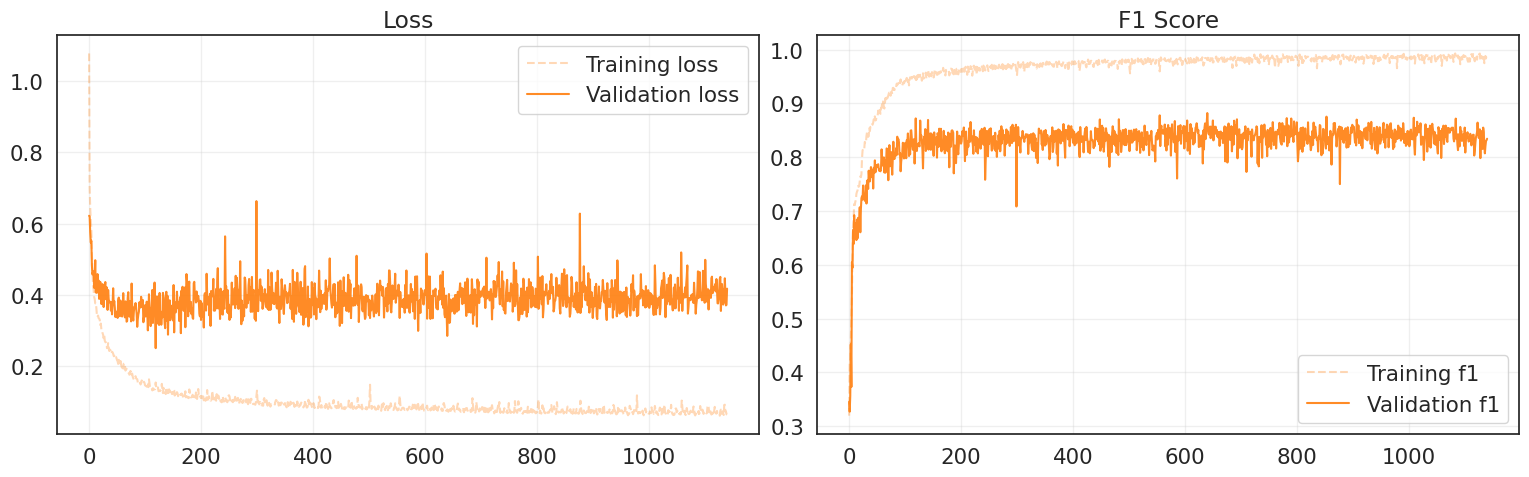

In [24]:
# @title Train Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9462
Precision over the validation set: 0.9196
Recall over the validation set: 0.8505
F1 score over the validation set: 0.8821


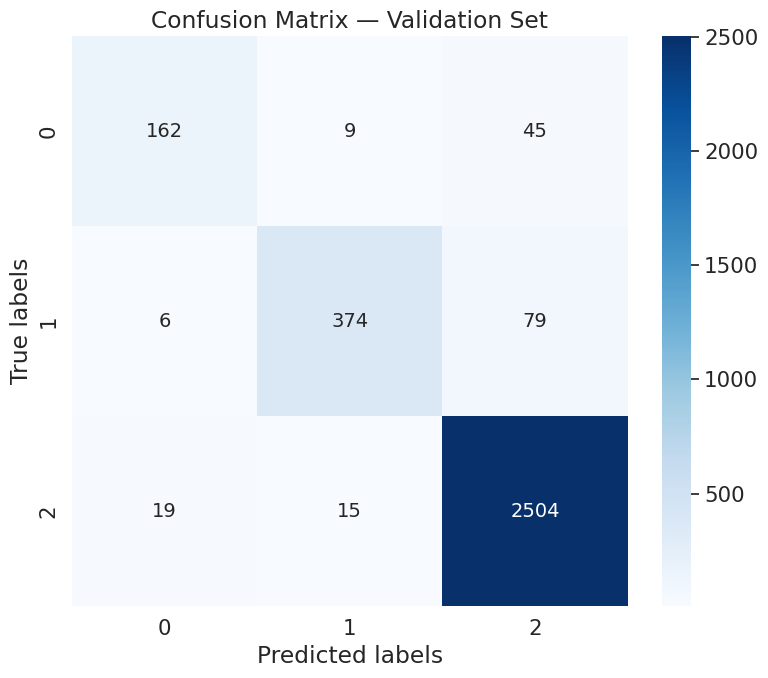

In [25]:
# @title Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average=f1_average)
val_rec = recall_score(val_targets, val_preds, average=f1_average)
val_f1 = f1_score(val_targets, val_preds, average=f1_average)
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

# Test

In [26]:
def build_test_sequences(df, features, window=200, stride=200):
    """
    Builds sequences for inference from the test set.
    This version does not handle labels but tracks sample indices.
    """
    assert window % stride == 0
    dataset = []
    sample_indices = []

    # Iterate over unique sample IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp = df[df['sample_index'] == id][features].values

        # Calculate padding length to ensure full windows
        padding_len = (window - len(temp) % window) % window

        # Create zero padding and concatenate with the data if needed
        if padding_len > 0:
            padding = np.zeros((padding_len, len(features)), dtype='float64')
            temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with their original sample_index
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            sample_indices.append(id)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)

    return dataset, sample_indices

In [27]:
# Instantiate model for test
inference_model = AttentionClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=3,
    dropout_rate=DROPOUT_RATE,
).to(device)

model_name = experiment_name
model_path = "models/" + model_name + "_model.pt"
inference_model.load_state_dict(torch.load(model_path, map_location=device)) # Load the best model saved on file after training

inference_model.eval()

print("Model loaded successfully and set to evaluation mode.")

Model loaded successfully and set to evaluation mode.


In [28]:
# 1. Build sequences from the preprocessed test data
# Use the same window and stride as in training for consistency.
test_x_seq, test_sample_indices = build_test_sequences(
    X_test,
    features,
    window=WINDOW_SIZE,
    stride=STRIDE
)

print(f"Created {len(test_x_seq)} sequences from the test set.")

# 2. Create a TensorDataset and DataLoader for the test set
# The dataset only contains the input sequences (no labels).
test_ds = TensorDataset(torch.from_numpy(test_x_seq).float())

test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Created 35748 sequences from the test set.


In [29]:
all_predictions = []

# 1. Run inference on the test set
print("Running inference on test data...")
with torch.no_grad():
    for (inputs,) in test_loader:  # Note the comma to unpack the single-item tuple
        inputs = inputs.to(device)

        # Forward pass
        logits = inference_model(inputs)

        # Get predictions (the class with the highest logit)
        predictions = logits.argmax(dim=1).cpu().numpy()
        all_predictions.extend(predictions)

print("Inference complete.")

# 2. Aggregate predictions for each sample_index
# We have multiple predictions per sample, so we take the most common one (mode).
df_preds = pd.DataFrame({
    'sample_index': test_sample_indices,
    'prediction': all_predictions
})

# Group by sample_index and find the most frequent prediction
final_preds = df_preds.groupby('sample_index')['prediction'].apply(lambda x: x.mode()[0]).reset_index()

print("Predictions aggregated by sample_index.")

Running inference on test data...
Inference complete.
Predictions aggregated by sample_index.


In [30]:
# 1. Convert numeric predictions back to original string labels
final_preds['label'] = label_encoder.inverse_transform(final_preds['prediction'])

# 2. Create the final submission DataFrame with the required columns
submission_df = final_preds[['sample_index', 'label']]

# 3. Save the DataFrame to a CSV file
submission_path = current_dir + '/submissions/submission_' + model_name + '.csv'
submission_df.to_csv(submission_path, index=False)

print(f"Submission file saved to '{submission_path}'")
print("\nFirst 5 rows of the submission file:")
print(submission_df.head())

Submission file saved to '/gdrive/My Drive/ANN-1stChallenge/submissions/submission_final_nooutl_2.csv'

First 5 rows of the submission file:
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain


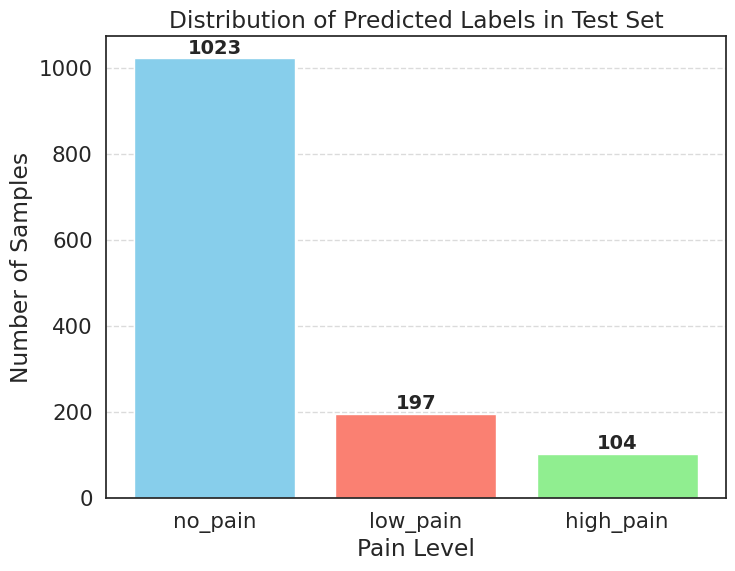

In [31]:
# @title Plot test prediction distribution
n_np = len(submission_df[submission_df['label'] == 'no_pain'])
n_lp = len(submission_df[submission_df['label'] == 'low_pain'])
n_hp = len(submission_df[submission_df['label'] == 'high_pain'])

# Data for plotting
labels = ['no_pain', 'low_pain', 'high_pain']
counts = [n_np, n_lp, n_hp]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen'])

# Add titles and labels for clarity
plt.title('Distribution of Predicted Labels in Test Set')
plt.xlabel('Pain Level')
plt.ylabel('Number of Samples')

# Add the count numbers on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()